# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [2]:
# Download the data
# if not os.path.exists('/content/aerialseq.npy'):
#     !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
# if not os.path.exists('/content/antseq.npy'):
#     !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [3]:
from scipy.interpolate import RectBivariateSpline

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    p = np.zeros((6,1))
    delta_p = np.zeros((6,1))
    delta_p_length = threshold
    
    H = It.shape[0]
    # print("H: ",H)
    W = It.shape[1]
    # print("W: ",W)

    xVals = np.arange(0,W,1)
    yVals = np.arange(0,H,1)

    yGrid, xGrid = np.meshgrid(yVals,xVals,indexing="ij")
    # print(xGrid)
    # print(yGrid)
    xGrid_flat = xGrid.ravel()
    yGrid_flat = yGrid.ravel()
    oneGrid_flat = np.zeros_like(xGrid_flat) + 1
    points_flat = np.vstack((xGrid_flat,yGrid_flat,oneGrid_flat)) # [x_list;y_list;1_list]
    # print(points_flat)

    T_t = np.copy(It)
    T_t_flat = T_t.ravel()

    # print(xGrid)
    # print(yGrid)
    rbs_IW = RectBivariateSpline(yVals,xVals,It1)
    gradientX = np.ravel(np.gradient(It1,axis=1))
    gradientY = np.ravel(np.gradient(It1,axis=0))
    
    i = 0
    while (i < num_iters) and (delta_p_length >= threshold):
        p1 = p[0,0]
        p2 = p[1,0]
        p3 = p[2,0]
        p4 = p[3,0]
        p5 = p[4,0]
        p6 = p[5,0]
        M = np.array([[1 + p1, p2, p3], [p4, 1 + p5, p6]])

        points_flat_tf = M@points_flat
        xGrid_tf_flat = points_flat_tf[0,:]
        yGrid_tf_flat = points_flat_tf[1,:]
        xGrid_tf = np.reshape(xGrid_tf_flat,(H,W))
        yGrid_tf = np.reshape(yGrid_tf_flat,(H,W))
        IW = rbs_IW.ev(xGrid_tf,yGrid_tf)
        IW_flat = IW.ravel()

        maskX = np.logical_and(xGrid_tf_flat<W,xGrid_tf_flat>=0)
        maskY = np.logical_and(yGrid_tf_flat<H,yGrid_tf_flat>=0)
        maskAll = maskX*maskY
        # print("Mask: ",maskAll.shape)
        x_flat_short = xGrid_tf_flat[maskAll]
        y_flat_short = yGrid_tf_flat[maskAll]
        # print("IW flat: ",IW_flat.shape)
        IW_flat_short = IW_flat[maskAll]
        T_t_flat_short = T_t_flat[maskAll]

        b = (T_t_flat_short - IW_flat_short).T # (N,1)

        gradientX_short = gradientX[maskAll]
        gradientY_short = gradientY[maskAll]
        gradientMatrix = np.vstack((gradientX_short,gradientY_short)).T # (N,6)
        # print(gradientMatrix.shape)

        N = gradientX_short.size
        # print(N)

        A = np.zeros((N,6))
        A[:,0] = gradientX_short*x_flat_short
        A[:,1] = gradientY_short*x_flat_short
        A[:,2] = gradientX_short*y_flat_short
        A[:,3] = gradientY_short*y_flat_short
        A[:,4] = gradientX_short*1
        A[:,5] = gradientY_short*1

        delta_p = np.linalg.lstsq(A,b,rcond=None)[0]

        # A = gradientMatrix*dWdp # (1,2)(2,6) = (1,6) --> (N,6)
        # b = T_t - IW # (N,1)

        # Ax = b

        i = i + 1
        delta_p_length = np.square(np.linalg.norm(delta_p,ord=2))
        p = p + delta_p


    p1 = p[0,0]
    p2 = p[1,0]
    p3 = p[2,0]
    p4 = p[3,0]
    p5 = p[4,0]
    p6 = p[5,0]
    M = np.array([[1 + p1, p2, p3], [p4, 1 + p5, p6]])
    # print(M)
    # plt.figure(4)
    # plt.imshow(T_t)
    # plt.figure(5)
    # plt.imshow(IW)
    # print(T_t.shape)
    # print(IW.shape)

    # print(points_flat.shape)
    
    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

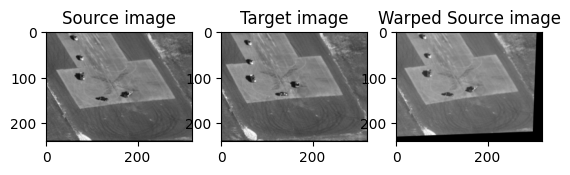

In [4]:
import cv2

num_iters = 100 # Defaults to 100
threshold = 0.01
seq = np.load("data\\aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# plt.figure()
# plt.imshow(It1-warped_It)

# Q3.2: Moving Object Detection (10 points)

In [11]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
    absDiff = np.abs(It1 - warped_It)
    mask1 = absDiff > tolerance
    mask2 = absDiff < np.max(absDiff)*0.95
    mask = mask1*mask2
    # ===== End of code =====

    return mask


## Q3.3: Tracking with affine motion (10 points)

In [12]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        if (i == seq.shape[2]-1):
            It = seq[:,:,i]
            It1 = seq[:,:,i]
        else:
            It = seq[:,:,i]
            It1 = seq[:,:,i+1]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)
        # print(mask)
    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [13]:
seq = np.load("data\\antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 20 #
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:56<00:00,  2.18it/s]


Ant Sequence takes 56.989569 seconds


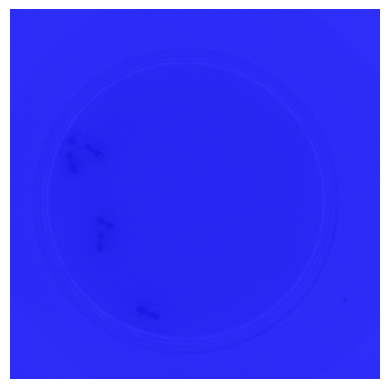

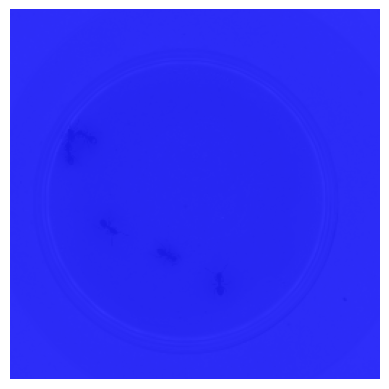

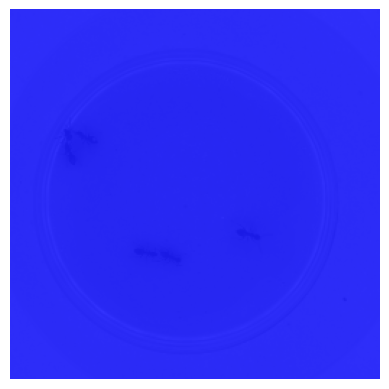

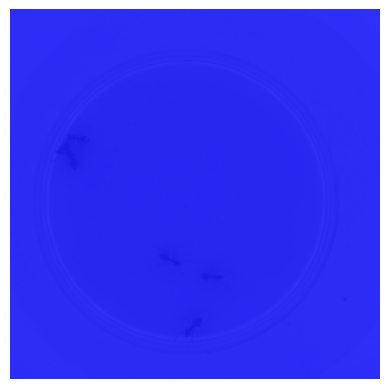

In [14]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]
    # print(masks[0,0,0])

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [15]:
seq = np.load("data\\aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 20
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

 68%|██████▊   | 102/149 [00:57<00:26,  1.80it/s]

: 

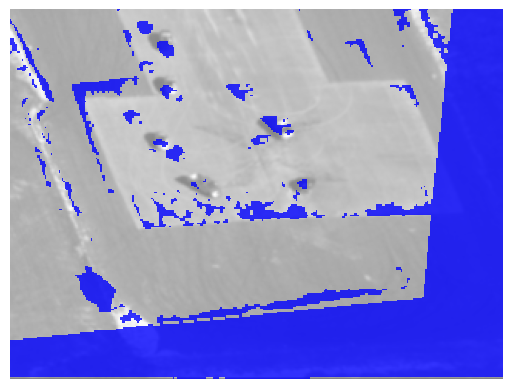

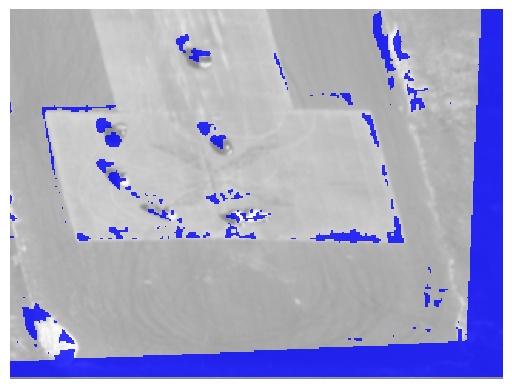

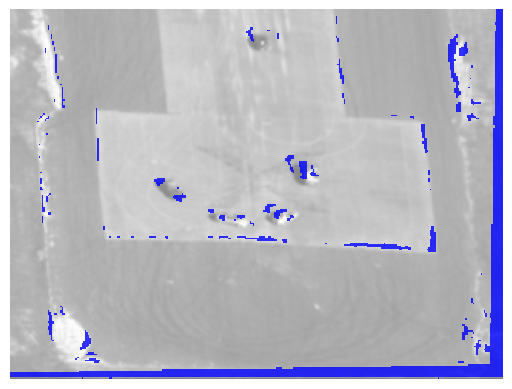

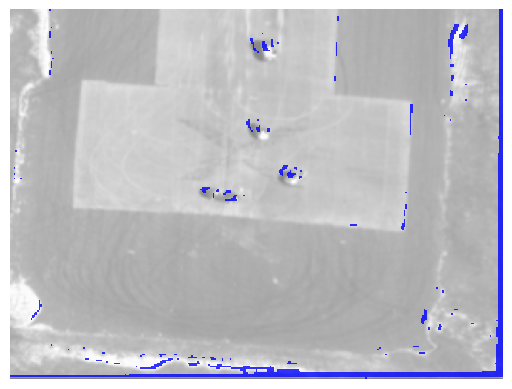

In [ ]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')